The problem statement at hand is to classify a dog into one of the ten breeds given. For this, we are using the [dataset](https://www.kaggle.com/c/dog-breed-identification) from Kaggle which contains around 10,000 images spanned across 120 breeds.
 
Our task is to build ResNet50 acrhitecture to classify a given dog into one of the 10 breeds.

Let us start by importing the necessary libraries.

(To code this model, I am taking the help of Jupyter Kernels from Kaggle)


In [1]:
import os
import keras
from keras.layers import Add,Input,Conv2D,MaxPool2D, Flatten, Dense, Activation, GlobalAveragePooling2D,MaxPooling2D
from keras.layers import BatchNormalization, Dropout, SpatialDropout2D, ZeroPadding2D, Activation, AveragePooling2D
from keras.layers import UpSampling2D
from keras.initializers import glorot_uniform, he_normal
from keras.regularizers import l1,l2,l1_l2
from keras.models import Model
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler, TensorBoard
import datetime
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score,accuracy_score, f1_score
import seaborn as sns

In [2]:
print('keras',keras.__version__)
print('sklearn',sklearn.__version__)
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('matplotlib',matplotlib.__version__)

keras 2.4.3
sklearn 0.23.2
pandas 1.1.5
numpy 1.19.5
matplotlib 3.3.3


In [3]:
os.chdir('../input/labels')
labels_df = pd.read_csv('labels.csv')   #Load the labels.csv file which contain the image paths with labels

In [4]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
#The following are the breeds, into one of  which we have to classify the input image
breeds_to_predict = ['malamute','pug','saint_bernard','tibetan_mastiff',
                     'scottish_deerhound','beagle','chihuahua','doberman','french_bulldog','golden_retriever']
len(breeds_to_predict)

10

In [6]:
#Changing all the remaining breeds to 'other' 
def assign_other_breed(x):
    if x not in breeds_to_predict:
        return 'other'
    return x
labels_df['breed'] = labels_df['breed'].apply(assign_other_breed)
labels_df['breed'].value_counts()

other                 9381
scottish_deerhound     126
beagle                 105
pug                     94
saint_bernard           84
malamute                81
doberman                74
chihuahua               71
french_bulldog          70
tibetan_mastiff         69
golden_retriever        67
Name: breed, dtype: int64

In [7]:
# In the labels.csv file, only the image names were guiven without their extension. Here we are appending .jpg to each file name
def include_format(x):
    return x+'.jpg'
labels_df['id'] = labels_df['id'].apply(include_format)
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,other
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,other
2,001cdf01b096e06d78e9e5112d419397.jpg,other
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,other
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


On changing all the remaining breeds to 'Other', a heavy imbalance is created. Also the other category contains 110 breeds which contain different patterns in the images. The model might get confused in leraning all these features as others . These are the 2 reasons for dropping the 'other' category.  

In [8]:
labels_df = labels_df[labels_df['breed']!='other']
labels_df['breed'].value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

Let us assign a number to each breed by Label Encoding. This will help us in interpreting the results at the time of predictions. We are converting the encoded values to strings as that is the expectation for target label while using Image Data Genarator to facilitate training

In [9]:
enc = LabelEncoder()
labels_df['encoded'] = enc.fit_transform(labels_df['breed'])
labels_df['encoded'] = labels_df['encoded'].apply(str)
labels_df.head()

,id,breed,encoded
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,4
9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound,8
20,008b1271ed1addaccf93783b39deab45.jpg,doberman,2
25,00a366d4b4a9bbb6c8a63126697b7656.jpg,golden_retriever,4
37,0100f55e4f0fe28f2c0465d3fc4b9897.jpg,golden_retriever,4


Let us create a data frame to look at all the unique breeds with their file paths. This will help us in plotting a sample image of all the 10 breeds of dogs. This step is to just get an idea about the data we are dealing with 

In [10]:
unique_df =  labels_df.groupby('breed').first()
unique_df

,id,encoded
breed,,
beagle,0566a60d7504a6fad4161d0ef2765a34.jpg,0
chihuahua,0206c12e8984e3c8a166cc272de25d6f.jpg,1
doberman,008b1271ed1addaccf93783b39deab45.jpg,2
french_bulldog,099b068027c41251d29f75a311cc5e5c.jpg,3
golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg,4
malamute,01f429667104c0c5a5f321700f15435c.jpg,5
pug,023e4e28415506e0deddcbd8f8bdab29.jpg,6
saint_bernard,039bdddd8546f0fafdf984b810d1138b.jpg,7
scottish_deerhound,0042188c895a2f14ef64a918ed9c7b64.jpg,8


Lets create a dictionary out of this dataframe mapping the breed to its's encoded values

In [11]:
keys = unique_df.index.values
values = unique_df.encoded.values
breed_encoded_values = dict(zip(keys,values))
breed_encoded_values

{'beagle': '0',
 'chihuahua': '1',
 'doberman': '2',
 'french_bulldog': '3',
 'golden_retriever': '4',
 'malamute': '5',
 'pug': '6',
 'saint_bernard': '7',
 'scottish_deerhound': '8',
 'tibetan_mastiff': '9'}

In [12]:
os.chdir('../dog-breed')

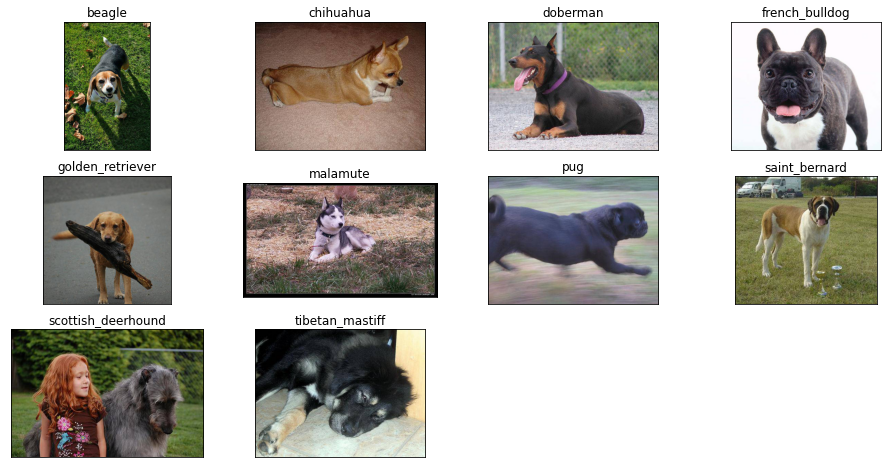

In [13]:
fig = plt.figure(figsize=(16,8))
for i,j in enumerate(unique_df.iterrows()):
    ax = fig.add_subplot(3,4,i+1)
    ax.set_title(j[0])
    pil_img = Image.open(os.path.join(j[1].values[0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(pil_img)

After removing all the dogs of other breeds, we can see that we only have 841 examples spanning across 10 classes. This is very less data for us to classify different breeds of dogs. Let's try Data Augmentation techniques by flipping, rotating, moving the image(height and width wise) etc to generate more data from the existing images. 

After trying various augmentation techniques here for 30 epochs for each combination, I have arrived with the below combination. 

1. Zoom range of 0.2
2. Horizontal flip of the image
3. Shear range of 0.2

More augmentation techniques are only hampering the accuracy

Let us first see how the augmentation works taking one image as an example

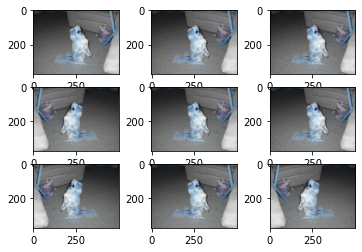

In [15]:
sample_img =cv2.imread('001cdf01b096e06d78e9e5112d419397.jpg')
sample_img = np.expand_dims(sample_img,axis=0)
sample_data_gen = ImageDataGenerator(horizontal_flip = True)
it = sample_data_gen.flow(sample_img, batch_size=1)
for i in range(9):
    # define subplot
    plt.subplot(3 ,3,1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
plt.show()

In [16]:
# Let us try to split the available dataset into 80/20 ratio for training/validation. Though the number of datapoints for
#class is very low, we still need to validate our results and hence I am splitting the data.
train_df, test_df = train_test_split(labels_df,test_size = 0.2,random_state = 42)

In [17]:
train_df['encoded'].value_counts()

8    102
0     84
6     79
7     66
5     65
3     59
1     58
2     58
9     56
4     45
Name: encoded, dtype: int64

In [18]:
test_df['encoded'].value_counts()

8    24
4    22
0    21
7    18
2    16
5    16
6    15
1    13
9    13
3    11
Name: encoded, dtype: int64

Note : Image augmentation does not generate extra images. It simply inputs the transformed images of original while training different epochs which gives a chance to the model to learn different versions of same image. 

In [19]:
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2,zoom_range = 0.2,shear_range=0.2,horizontal_flip = True)
train_data_gen = datagen.flow_from_dataframe(dataframe=train_df,
                                             x_col = 'id',y_col = 'encoded',subset = 'training')

valid_data_gen =  datagen.flow_from_dataframe(dataframe=train_df,
                                             x_col = 'id',y_col = 'encoded',subset = 'validation')

Found 538 validated image filenames belonging to 10 classes.
Found 134 validated image filenames belonging to 10 classes.


Lets start building the model. The heart of ResNet 50 architecture consists of 4 stages with convolution followed by Identity blocks. The image size gradually decreases with an increase in the number of channels as the Network gets deeper. 
 
Convolution blocks generally decrease the size of the image while Identity blocks preserves the size of the image to the subsequent layers learning some features in the process.

In [20]:
def convolutional_block(input_feature_map, filter_sizes, stride=2, regularizer = None):
    
    filters_1, filters_2, filters_3 = filter_sizes
    X = input_feature_map
    
    X_shortcut = X

    X = Conv2D(filters=filters_1, kernel_size=(1, 1), strides=(stride, stride), padding='valid', 
               kernel_initializer=he_normal(seed=0))(X)
    
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=filters_2, kernel_size=(3, 3), strides=(1, 1), padding='same',  
               kernel_initializer=he_normal(seed=0), kernel_regularizer = regularizer)(X)
    
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=filters_3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_initializer=he_normal(seed=0))(X)
    
    X = BatchNormalization(axis=3)(X)

    X_shortcut = Conv2D(filters=filters_3, kernel_size=(1, 1), strides=(stride, stride), padding='valid', 
                        kernel_initializer=he_normal(seed=0))(X_shortcut)
    
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [21]:
def identity_block(input_feature_map, filter_sizes,regularizer = None):
   
    filters_1, filters_2, filters_3 = filter_sizes
    
    X = input_feature_map
    X_shortcut = X
   
    X = Conv2D(filters=filters_1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               kernel_initializer=he_normal(seed=0))(X)
    
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=filters_2, kernel_size=(3, 3), strides=(1, 1), padding='same', 
               kernel_initializer=he_normal(seed=0), kernel_regularizer = regularizer)(X)
    
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=filters_3, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               kernel_initializer=he_normal(seed=0))(X)
    
    X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [23]:
input_layer = Input(shape=(224,224,3))

X = Conv2D(64, (7, 7), strides=(2, 2), padding = 'same',kernel_initializer=he_normal(seed=0))(input_layer)
X = BatchNormalization(axis=3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

X = convolutional_block(X,filter_sizes=[64, 64, 256], stride=1)
X = identity_block(X,filter_sizes=[64, 64, 256])
X = identity_block(X,filter_sizes= [64, 64, 256])


X = convolutional_block(X,filter_sizes=[128, 128, 512],stride=2, regularizer = l2(0.01))
X = identity_block(X,filter_sizes= [128, 128, 512])
X = identity_block(X,filter_sizes= [128, 128, 512], regularizer = l2(0.01))
X = identity_block(X,filter_sizes= [128, 128, 512])

X = convolutional_block(X,filter_sizes=[256, 256, 1024], stride=2, regularizer = l2(0.01))
X = identity_block(X,filter_sizes= [256, 256, 1024])
X = identity_block(X,filter_sizes= [256, 256, 1024], regularizer = l2(0.01))
X = identity_block(X,filter_sizes= [256, 256, 1024])
X = identity_block(X,filter_sizes= [256, 256, 1024], regularizer = l2(0.01))
X = identity_block(X,filter_sizes=[256, 256, 1024])

X = X = convolutional_block(X,filter_sizes=[512, 512, 2048], stride=2, regularizer = l2(0.01))
X = identity_block(X,filter_sizes=[512, 512, 2048])
X = identity_block(X,filter_sizes=[512, 512, 2048],regularizer = l2(0.01))

X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

X = Flatten()(X)
X=Dense(1024, activation='relu',kernel_initializer=he_normal(seed=0))(X)
X=Dropout(0.4)(X)
X=Dense(512, activation='relu',kernel_initializer=he_normal(seed=0))(X)
X=Dropout(0.3)(X)
X=Dense(256, activation='relu',kernel_initializer=he_normal(seed=0))(X)
X=Dropout(0.2)(X)
X=Dense(128, activation='relu',kernel_initializer=he_normal(seed=0))(X)
output = Dense(10,activation='softmax',kernel_initializer=glorot_uniform(seed=0))(X)


model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01),loss='categorical_crossentropy',
              metrics = ['accuracy'])

We have recreated the ResNet50 architecture above. The next steps are to try and fit the model using various hyper parameters and callbacks. Below are the findings.

Note : Each of the below combinations/parameters had to be run for a minimum of 60 epochs to get some reasonable result. 60 epochs takes a lot of space in displaying. Hence the model is fit with the best combination and that alone is recorded in this notebook.

1) ReLU activations were the go-to functions in the recent past owing to their simpler calculations. All the activations were set to ReLU with the output layer activation being softmax which gives a relative probability of each class with all the probability scores adding up to 1. ReLU activations were emperically found out to go well with 'he_normal' initializers and the softmax with 'glorot_uniform'.

2) Initially if the model is run without any dropouts and Regularizers, the model is overfitting by a huge margin with the train accuracy going as high as 0.60 for 30 epochs while the validation accuracy stays at 0.15. In order to deal with this, I have tried implementing dropouts for Dense, Spatial Dropouts for Convolution Layers and Kernel Regularizers. Spatial Dropouts turned out to be denting the model training procedure. The reason for this might be that the convnets are unable to learn the features from the image. Hence dropped the Spatial Dropouts and went with the regular Dropouts. Regarding Regularizers, I have tried L1, L2 and L1_L2. L2 proved out to be good for the architecture and data combination.

3) The training and validation accuracy is fluctuating a lot. To control this, I have tried using learning rate scheduler and ReduceLRonPlateau callbacks. Unfortunately, they are not allowing the model to learn the features while training and hampering the train accuracy itself. Hence dropped the idea of implementing it. Kaggle Kernels are currrently not supporting the TensorBoard callback and hence couldn't implement it.

4) Have tried the optimizers Adam, SGD and RMSprop out of which Adam outperformed the rest.

5) Have tried implementing additional convnets but they are only decreasing the accuracy compared to the ResNet50 architecture

6) Even after all this steps, the accuracy of the training and Validation is still not satisfactory. I feel that is something to do with the amount of data present to train each class. Hence I went ahead and implemented the model with the below fit paramters using Model Checkpoint callback to save the weights of the model which gives the highest validation accuracy. This is done by setting the monitor parameter to 'val_accuracy' and the model = 'max'.

Note : Early stopping wasn't implemented owing to the fluctuations in the accuracy.

In [24]:
checkpoint_file_path = '../../working/weights.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file_path,save_weights_only=True,
                            monitor='val_accuracy',mode='max',save_best_only=True)
callbacks =[model_checkpoint_callback]
model.fit(train_data_gen,epochs = 90, validation_data= valid_data_gen, callbacks = callbacks)

Epoch 1/90
17/17 [==============================] - 29s 1s/step - loss: 69.1958 - accuracy: 0.0959 - val_loss: 6001474.5000 - val_accuracy: 0.0373
Epoch 2/90
17/17 [==============================] - 14s 827ms/step - loss: 44.9473 - accuracy: 0.0768 - val_loss: 56539588.0000 - val_accuracy: 0.1045
Epoch 3/90
17/17 [==============================] - 14s 859ms/step - loss: 36.3372 - accuracy: 0.1080 - val_loss: 68639.5859 - val_accuracy: 0.0970
Epoch 4/90
17/17 [==============================] - 14s 802ms/step - loss: 27.9700 - accuracy: 0.1112 - val_loss: 6217.5283 - val_accuracy: 0.1119
Epoch 5/90
17/17 [==============================] - 14s 805ms/step - loss: 22.9924 - accuracy: 0.1628 - val_loss: 1695.3231 - val_accuracy: 0.1418
Epoch 6/90
17/17 [==============================] - 14s 856ms/step - loss: 19.0247 - accuracy: 0.1041 - val_loss: 43.5857 - val_accuracy: 0.1045
Epoch 7/90
17/17 [==============================] - 14s 816ms/step - loss: 16.1524 - accuracy: 0.1083 - val_loss: 1

Epoch 58/90
17/17 [==============================] - 14s 824ms/step - loss: 2.2807 - accuracy: 0.3017 - val_loss: 2.5238 - val_accuracy: 0.2463
Epoch 59/90
17/17 [==============================] - 15s 885ms/step - loss: 2.2357 - accuracy: 0.3049 - val_loss: 2.5424 - val_accuracy: 0.2537
Epoch 60/90
17/17 [==============================] - 14s 820ms/step - loss: 2.1588 - accuracy: 0.3263 - val_loss: 2.3824 - val_accuracy: 0.2537
Epoch 61/90
17/17 [==============================] - 15s 865ms/step - loss: 2.0450 - accuracy: 0.3932 - val_loss: 2.4347 - val_accuracy: 0.2164
Epoch 62/90
17/17 [==============================] - 14s 838ms/step - loss: 2.2591 - accuracy: 0.3608 - val_loss: 2.8743 - val_accuracy: 0.2537
Epoch 63/90
17/17 [==============================] - 15s 866ms/step - loss: 2.4327 - accuracy: 0.3193 - val_loss: 2.6980 - val_accuracy: 0.2164
Epoch 64/90
17/17 [==============================] - 14s 824ms/step - loss: 2.1536 - accuracy: 0.4062 - val_loss: 2.6092 - val_accuracy:

This is just a trail step to load the weights of the model trained. We will use this step while inferencing i.e using a flask API to classify a dog

In [48]:
 model.load_weights('../../working/weights.h5')

Let us try to predict one image and see if we are receiving prediction probabilities for each class. 

Steps to follow to predict one image separately. The same technique will be used while predicting using Flask API

1) Since our trained Model receives input image with the shape of (224,224,3), we first resize it.

2) We then convert the image format to an array format

3) Scaling down the image to the range of 0-1 is a compulsory step. Without this step, the model predictions will result in absurd predictions. For example, all the classes will have same probabilities for each image, same class being predicted with a probability of 1 for every image

In [25]:
img =Image.open('000bec180eb18c7604dcecc8fe0dba07.jpg')
img = img.resize((224,224))
arr = np.array(img)
arr = arr/255.0
arr = np.expand_dims(arr,axis=0)
model.predict(arr)

array([[0.32792702, 0.11414397, 0.00987139, 0.05966798, 0.0224006 ,
        0.05202878, 0.09192155, 0.2949225 , 0.00913642, 0.0179798 ]],
      dtype=float32)

Let us try and predict the breeds for the dogs present in the test_df and validate them with the available metrics. Reusing the datageneartor initialised will help us in avoiding the reshaping and resizing steps.

In [26]:
test_data_gen = datagen.flow_from_dataframe(dataframe=test_df,
                                             x_col = 'id',y_col = 'encoded')
predictions = model.predict(test_data_gen)
predicted_classes = np.argmax(predictions,axis=1)
true_classes = test_df['encoded'].apply(int).values

Found 169 validated image filenames belonging to 10 classes.


**Confusion Matrix:**

Text(87.0, 0.5, 'Actual Classes')

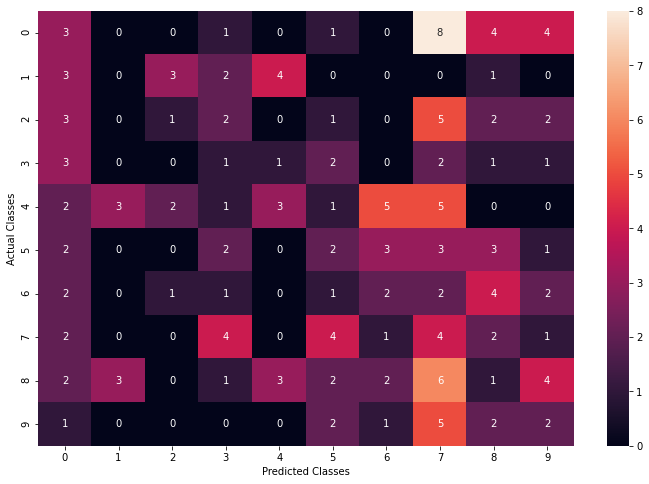

In [27]:
con_matrix = confusion_matrix(true_classes,predicted_classes)
fig = plt.figure(figsize=(12,8))
sns.heatmap(con_matrix, annot = True)
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')

On plotting the confusion matrix using a heatmap with annotations, we can get a better understanding of the predictions for every class. All the diagonal elements are the True positives i.e the dogs belonging to their respective breeds are correctly classified by the model. From the confusion matrix accuracy, precision and Recall can be deduced.

Accuracy = all the correctly classified examples/ total number of examples
Precision = all the correctly classified examples/ Total number of examples classified as belonging to the particular class
Recall = all the correctly classified examples/ Total number of examples  belonging to the particular class


Precision and Recall can be calculated class-wise. In our case, these two metrics doesn't exactly have great importance. 
For example in cases like Covid Detection, we would like to have a high Recall implying False Negatives cannot be encouraged at all. We would be okay with classifying a healthy patient as COVID +ve, but cannot risk an affected person being classified as Negative.

In [28]:
micro_precision = round(precision_score(true_classes, predicted_classes, average = 'micro'),3)
macro_precision = round(precision_score(true_classes, predicted_classes, average = 'macro'),3)
weighted_precision = round(precision_score(true_classes, predicted_classes, average = 'weighted'),3)

micro_recall = round(recall_score(true_classes, predicted_classes, average = 'micro'),3)
macro_recall = round(recall_score(true_classes, predicted_classes, average = 'macro'),3)
weighted_recall = round(recall_score(true_classes, predicted_classes, average = 'weighted'),3)

micro_f1 = round(f1_score(true_classes, predicted_classes, average = 'micro'),3)
macro_f1 = round(f1_score(true_classes, predicted_classes, average = 'macro'),3)
weighted_f1 = round(f1_score(true_classes, predicted_classes, average = 'weighted'),3)


metrics_dict = {'Precision':[micro_precision,macro_precision,weighted_precision],
             'Recall':[micro_recall,macro_recall,weighted_recall],
             'F1-score':[micro_f1,macro_f1,weighted_f1]}

pd.DataFrame(metrics_dict, index = ['Micro', 'Macro', 'Weighted'])

,Precision,Recall,F1-score
Micro,0.112,0.112,0.112
Macro,0.115,0.111,0.106
Weighted,0.121,0.112,0.109


As this is a multiclass classification problem, we have micro and macro precisions.

Micro Precision: Takes sum of all true positives and false positives, and divides TP/TP+FP

Macro Precision: Takes True positives and False Negatives class wise, calculates precision and then computes the mean irresepctive of the number of labels belonging to each class.

Weighted Precision : Is similar to Macro Precision but takes the number of points from each class into account

Same goes for Recall except all the False Positives are replaced with False Negatives

F1-score is the harmonic mean of both Precision and Recall


**Please refer to this [blog](https://medium.com/@rushya.kambhampati/evaluation-metrics-for-classification-1ab1dfdaaf29) that I have written regarding the classifcation metrics in detail**

ROC AUC Score:

In order to calculate the ROC AUC score, mere classes are not sufficient. It takes the probabilities of each class being the output and then plots a curve between True Positive rate and False Positive Rate. In order to plot this, the true labels must be one hot encoded. This is one of the go to metrics in case of imbalanced datasets. Though in our case, the dataset is balanced,let's have a look at this. 

In [29]:
ohe = OneHotEncoder()
true_one_hot_values = ohe.fit_transform(test_df[['encoded']]).toarray() 
roc_score = round(roc_auc_score(true_one_hot_values, predictions),3)
roc_score

0.509

We see that the ROC AUC score is 0.509. A score of 0.5 can mean that model is randomly classifying an image to one of the available classes. Unfortunately, this is not something we wanted. 

**Overall, all the metrics on our test data set are not up our expectations. There might be few reasons for this.**

1. The Model complexity of ResNet50 may not be sufficient to classify the images. Generally this is not the case. ResNet50 is one of the most comprehensive archirectures that can solve complicated problems enabling deeper layers to learn intricate details from the image.

2. We have very less data for each of the breeds. This might have been very low for the complex architecture that we have written. Additionally, all the classes belonged to dogs which implies there might have been similarities betweeb different breeds which makes the model all the more difficult to learn the patterns.

3.The model weights saved are of the size 220 MB and hence they couldn't be uploaded to GitHub.


I would have loved to score brownies points for deploying the Flask API and provide an end point. Unfortunately, there were few constraints pertaining to size of the model and also the dependencies. However, I have deployed an API locally in flask. I have placed the API folder in this git hub repo. I would like you to have a look at that API. I have used readily available templates for HTML/CSS and Javascript from the web and written the API in flask to render the model output. 

